In [15]:
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

%matplotlib inline

In [2]:
from imblearn.over_sampling import SMOTE 

In [3]:
data_path = 'D://Dataset/support-ticket-classification/'

ddata = pd.read_csv(data_path + 'all_tickets.csv')

In [4]:
ddata.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


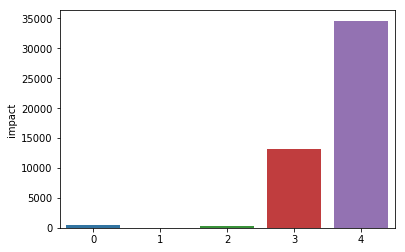

In [5]:
sns.barplot(y = ddata.impact.value_counts(), x = ddata.impact.value_counts().index)

In [6]:
ddata.impact.value_counts()

4    34621
3    13184
0      471
2      228
1       45
Name: impact, dtype: int64

## Cleansing

In [7]:
stopword = stopwords.words('english')

stem = PorterStemmer()

lemma = WordNetLemmatizer()

In [8]:
def cleansing(sentence):
    word_list = word_tokenize(sentence)
    word_list = [word for word in word_list if word not in stopword]
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [stem.stem(word) for word in word_list]
    word_list = [lemma.lemmatize(word) for word in word_list]
    
    text = " ".join(word_list)
    
    return text

In [9]:
ddata['body_cleansing'] = ddata.body.apply(cleansing)

## Feature extraction

In [10]:
cv = CountVectorizer()

In [11]:
X = cv.fit_transform(ddata.body_cleansing)

## Model

In [12]:
skf = StratifiedKFold(n_splits=5)

In [16]:
score_list = []
for train, test in tqdm(skf.split(X, ddata.impact)):
    X_train, y_train = X[train], ddata.loc[train, 'impact']
    X_test, y_test = X[test], ddata.loc[test, 'impact']
    
    ## Oversampling
    smt = SMOTE(random_state = 123)
    X_train, y_train = smt.fit_resample(X_train, y_train)
    
    mnb = MultinomialNB()
    mnb.fit(X_train, y_train)
    y_pred = mnb.predict(X_test)
    score_list.append(eval(y_test, y_pred))

5it [03:18, 39.71s/it]


In [17]:
pd.DataFrame(score_list)

,f1-score,precision,recall
0,0.437865,0.416941,0.482379
1,0.458725,0.431040,0.532949
2,0.457854,0.426028,0.534232
3,0.488572,0.456328,0.562444
4,0.491895,0.463156,0.559312


## Evaluation

In [14]:
def eval(y_true, y_pred):
    f1score = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average = 'macro')
    
    return {'f1-score': f1score,
            'recall': recall,
            'precision': precision
            }